# Find all human kinases in ChEMBL

This notebook maps Uniprot IDs to ChEMBL target IDs and produces a helper CSV file useful in other notebooks

In [2]:
from pathlib import Path
import urllib.request

import requests
import bs4
import pandas as pd

In [3]:
REPO = (Path(_dh[-1]) / "..").resolve()
DATA = REPO / 'data'

## 01. Obtain UniprotIDs for all human kinases

There are several sources that can be used to identify the human kinome in Uniprot:

* [KinHub](http://kinhub.org/kinases.html)
* [KLIFS](https://klifs.vu-compmedchem.nl/)
* [UniProt](https://www.uniprot.org/docs/pkinfam.txt)'s _Human and mouse protein kinases: classification and index_.
* Scientific literature

There are also several nomenclatures commonly used to refer to kinases: xName, Manning, HGNC... For  completeness, we will try to merge all these sources into a single table we can use in later exercises.

### 01.1 KinHub

This part is straightforward: it retrieves the table listed at [Kinhub.org](http://kinhub.org/kinases.html) with `requests` and `beautifulsoup`.

In [4]:
r = requests.get("http://kinhub.org/kinases.html")
r.raise_for_status()
html = bs4.BeautifulSoup(r.text)

In [5]:
table = html.find('table')
columns = [cell.text.strip() for cell in table.find('thead').find_all('th')]
records = [[cell.text.strip() for cell in row.find_all('td')] for row in table.find('tbody').find_all('tr')]
kinhub = pd.DataFrame.from_records(records, columns=columns).sort_values(by="xName")
kinhub

,xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID
336,AAK1,AAK1,AAK1,AP2-associated protein kinase 1,Other,NAK,,Q2M2I8
0,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,,P00519
24,ABL2,ARG,ABL2,Abelson tyrosine-protein kinase 2,TK,Abl,,P42684
529,ABR,ABR,ABR,Active breakpoint cluster region-related protein,Atypical,BCR,,Q12979
1,ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,,Q07912
...,...,...,...,...,...,...,...,...
274,p38g,p38g,MAPK12,Mitogen-activated protein kinase 12,CMGC,MAPK,p38,P53778
209,p70S6K,p70S6K,RPS6KB1,Ribosomal protein S6 kinase beta-1,AGC,RSK,RSKp70,P23443
210,p70S6Kb,p70S6Kb,RPS6KB2,Ribosomal protein S6 kinase beta-2,AGC,RSK,RSKp70,Q9UBS0
477,skMLCK,skMLCK,MYLK2,Myosin light chain kinase 2,CAMK,MLCK,,Q9H1R3


## 01.2 KLIFS

In [6]:
r = requests.get("https://klifs.vu-compmedchem.nl/api/kinase_names?species=HUMAN")
r.raise_for_status()
data = r.json()
all_ids = [record["kinase_ID"] for record in data]

In [7]:
r = requests.get(f"https://klifs.vu-compmedchem.nl/api/kinase_information?kinase_ID={','.join(map(str, all_ids))}")
r.raise_for_status()
data = r.json()

In [8]:
items = []
for record in data:
    items.append({
        "KLIFS Name": record["name"],
        "HGNC Name": record["HGNC"],
        "Family": record["family"],
        "Group": record["group"],
        "Class": record["kinase_class"],
        "Kinase Name": record["full_name"],
        "UniprotID": record["uniprot"],
        "IUPHAR": record["iuphar"],
        "Pocket": record["pocket"],
        "KLIFS ID": record["kinase_ID"]
    })
klifs = pd.DataFrame.from_dict(items).sort_values(by="KLIFS Name")
klifs

,KLIFS Name,HGNC Name,Family,Group,Class,Kinase Name,UniprotID,IUPHAR,Pocket,KLIFS ID
276,AAK1,AAK1,NAK,Other,BIKE,AP2 associated kinase 1,Q2M2I8,1921,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,277
391,ABL1,ABL1,Abl,TK,,"ABL proto-oncogene 1, non-receptor tyrosine ki...",P00519,1923,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,392
392,ABL2,ABL2,Abl,TK,,"ABL proto-oncogene 2, non-receptor tyrosine ki...",P42684,1924,HKLGGGQYGEVYVVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIVTE...,393
393,ACK,TNK2,Ack,TK,,"tyrosine kinase, non-receptor, 2",Q07912,2246,EKLGDGSFGVVRRVAVKCLDFIREVNAMHSLDRNLIRLYGVKMVTE...,394
522,ACTR2,ACVR2A,STKR,TKL,Type2,activin A receptor type IIA,P27037,1791,EVKARGRFGCVWKVAVKIFSWQNEYEVYSLPGENILQFIGAWLITA...,523
...,...,...,...,...,...,...,...,...,...,...
251,p38g,MAPK12,MAPK,CMGC,p38,mitogen-activated protein kinase 12,P53778,1501,QPVGSGAYGAVCSVAIKKLRAYRELRLLKHMRENVIGLLDVYLVMP...,252
50,p70S6K,RPS6KB1,RSK,AGC,p70,ribosomal protein S6 kinase B1,P23443,1525,RVLGKGGYGKVFQFAMKVLHTKAERNILEEVKPFIVDLIYAYLILE...,51
51,p70S6Kb,RPS6KB2,RSK,AGC,p70,ribosomal protein S6 kinase B2,Q9UBS0,1526,RVLGKGGYGKVFQYAMKVLHTRAERNILESVKPFIVELAYAYLILE...,52
154,skMLCK,MYLK2,MLCK,CAMK,,myosin light chain kinase 2,Q9H1R3,1553,EALGGGKFGAVCTLAAKVIMVLLEIEVMNQLNRNLIQLYAAVLFME...,155


## 01.3 Pkinfam

UniProt maintains [a txt file](https://www.uniprot.org/docs/pkinfam.txt) with a kinase index: `pkinfam`. We can try to parse it and see what information we have there.

In [9]:
r = requests.get("https://www.uniprot.org/docs/pkinfam.txt")
r.raise_for_status()
text = r.text

In [66]:
items = []
current_category = None
lines = iter(text.splitlines())
for line in lines:
    if line.startswith("==="):  # this is a header
        line = next(lines)
        current_category = line.strip()
        next(lines)
        next(lines)
        continue
    if not line.strip() or not current_category or '_HUMAN' not in line:
        continue
    if line.startswith("---") and current_category:
        break
    
    fields = line.split()
    name = fields[0]
    uniprot_id = fields[2].replace("(", "").replace(")", "")
    items.append({
        'Name': name,
        'Family': current_category,
        'UniprotID': uniprot_id,
    })
pkinfam = pd.DataFrame.from_dict(items).sort_values(by="Name")
pkinfam

,Name,Family,UniprotID
403,AAK1,Other,Q2M2I8
313,AATK,Tyr protein kinase family,Q6ZMQ8
314,ABL1,Tyr protein kinase family,P00519
315,ABL2,Tyr protein kinase family,P42684
279,ACVR1,TKL Ser/Thr protein kinase family,Q04771
...,...,...,...
481,WNK2,Other,Q9Y3S1
482,WNK3,Other,Q9BYP7
483,WNK4,Other,Q96J92
401,YES1,Tyr protein kinase family,P07947


## All UniProt

Searching UniProt for all [human proteins with confirmed kinase activity](https://www.uniprot.org/uniprot/?query=keyword%3A%22Kinase+%5BKW-0418%5D%22+organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22&sort=score) shows 636 entries (queried on 2020.06.22). Programmatically, we can use the URL API for now.

[Details on URL queries](https://www.uniprot.org/help/uniprotkb_column_names)

In [114]:
from urllib.parse import quote
url = ("https://www.uniprot.org/uniprot/?query="
       #"keyword:%22Kinase%20[KW-0418]%22%20organism:%22Homo%20sapiens%20(Human)%20[9606]%22"
       + quote(r'(keyword:"Kinase [KW-0418]" OR goa:("kinase activity [0016301]") OR goa:("protein kinase activity [0004672]")) AND organism:"Homo sapiens (Human) [9606]"') +
       "&format=tab&force=true&columns=id,entry%20name,reviewed,protein%20names,genes&sort=name")
uniprot = pd.read_csv(url, sep="\t").rename(columns={"Entry": "UniprotID"})
reviewed_uniprot = uniprot[uniprot.Status=="reviewed"].drop("Status", axis=1)

In [115]:
reviewed_uniprot

,UniprotID,Entry name,Protein names,Gene names
1,O75191,XYLB_HUMAN,Xylulose kinase (Xylulokinase) (EC 2.7.1.17),XYLB
9,P0C1S8,WEE2_HUMAN,Wee1-like protein kinase 2 (EC 2.7.10.2) (Wee1...,WEE2 WEE1B
13,P30291,WEE1_HUMAN,Wee1-like protein kinase (WEE1hu) (EC 2.7.10.2...,WEE1
25,P01185,NEU2_HUMAN,Vasopressin-neurophysin 2-copeptin (AVP-NPII) ...,AVP ARVP VP
40,P35916,VGFR3_HUMAN,Vascular endothelial growth factor receptor 3 ...,FLT4 VEGFR3
...,...,...,...,...
4347,Q00013,EM55_HUMAN,55 kDa erythrocyte membrane protein (p55) (Mem...,MPP1 DXS552E EMP55
4356,O15530,PDPK1_HUMAN,3-phosphoinositide-dependent protein kinase 1 ...,PDPK1 PDK1
4360,O14874,BCKD_HUMAN,[3-methyl-2-oxobutanoate dehydrogenase [lipoam...,BCKDK
4361,Q05823,RN5A_HUMAN,2-5A-dependent ribonuclease (2-5A-dependent RN...,RNASEL RNS4


### Review results so far

KinHub lists 536 kinases, KLIFS 555, PkinFam 513, and a GO-based query on UniprotKB produces 741 rows. Let's compare the listed Uniprot IDs.

In [116]:
datasets = {
    "kinhub": kinhub,
    "klifs": klifs,
    "pkinfam": pkinfam,
    "reviewed_uniprot": reviewed_uniprot
}
uniprot_ids = {}
for label, df in datasets.items():
    original = df.UniprotID.tolist()
    subset = set(original)
    uniprot_ids[label] = subset
    diff = len(original) - len(subset)
    if diff:
        print(label, "has", diff, "duplicates")

kinhub has 14 duplicates
klifs has 13 duplicates


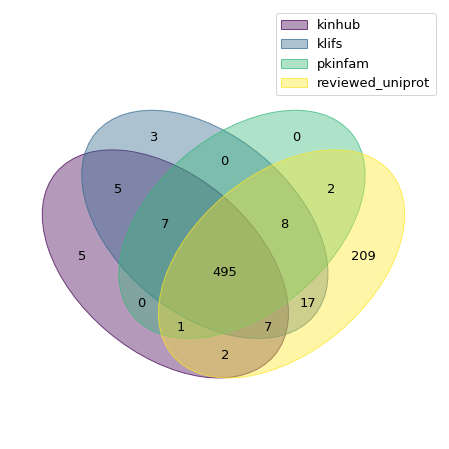

In [236]:
from venn import venn
venn(uniprot_ids);

So, how come UniProt is missing that many kinases (outside yellow)? It _should_ be the authoritative resource, right? Let's see.

In [238]:
only_pkinfam = uniprot_ids["pkinfam"].difference(uniprot_ids["kinhub"] | uniprot_ids["klifs"] | uniprot_ids["reviewed_uniprot"])
print("Only in pkinfam:", len(only_pkinfam))
for identifier in only_pkinfam:
    print(" ", identifier, "->", *pkinfam[pkinfam.UniprotID == identifier].Name)

print()
only_kinhub = uniprot_ids["kinhub"].difference(uniprot_ids["pkinfam"] | uniprot_ids["klifs"] | uniprot_ids["reviewed_uniprot"])
print("Only in KinHub:", len(only_kinhub))
for identifier in only_kinhub:
    print(" ", identifier, "->", *kinhub[kinhub.UniprotID == identifier].xName)

print()
only_klifs = uniprot_ids["klifs"].difference(uniprot_ids["pkinfam"] | uniprot_ids["kinhub"] | uniprot_ids["reviewed_uniprot"])
print("Only in KLIFS:", len(only_klifs))
for identifier in only_klifs:
    print(" ", identifier, "->", *klifs[klifs.UniprotID == identifier]["HGNC Name"])
    
print()
not_uniprot = (uniprot_ids["pkinfam"] | uniprot_ids["kinhub"] | uniprot_ids["klifs"]).difference(uniprot_ids["reviewed_uniprot"])
print("In total, not in uniprot:", len(not_uniprot))
for identifier in not_uniprot:
    print(" ", identifier)

Only in pkinfam: 0

Only in KinHub: 5
  Q12979 -> ABR
  Q9NRL2 -> BAZ1A
  B5MCJ9 -> TIF1D
  P53004 -> BLVRA
  Q6IBK5 -> GTF2F1

Only in KLIFS: 3
  O43921 -> EFNA2
  Q9H6X2 -> ANTXR1
  Q9UJY1 -> HSPB8

In total, not in uniprot: 20
  Q96RU8
  Q9H6X2
  Q9UJY1
  P25440
  Q9UPN9
  Q9Y4A5
  Q9UHY1
  Q96RU7
  Q12979
  Q92519
  Q9NRL2
  Q8IZE3
  O43921
  Q8NB16
  Q7Z7A4
  Q58F21
  Q15059
  B5MCJ9
  P53004
  Q6IBK5


What are these 20 kinases that are not considered to have a kinase activity, *but* other datasets have included? We can check the GO annotations:

In [217]:
for i, entry in enumerate(not_kinhub, 1):
    r = requests.get(fr"https://www.uniprot.org/uniprot/{entry}.txt")
    r.raise_for_status()
    print(i, entry)
    for line in r.text.splitlines():
        if line.startswith(("ID", "DE")):
            print(line)
        elif line.startswith("DR   GO;") and "; F:" in line:
            print(line)
    print()

1 Q6A1A2
ID   PDPK2_HUMAN             Reviewed;         396 AA.
DE   RecName: Full=Putative 3-phosphoinositide-dependent protein kinase 2;
DE            EC=2.7.11.1;
DE   AltName: Full=3-phosphoinositide-dependent protein kinase 2 pseudogene {ECO:0000305};
DR   GO; GO:0005524; F:ATP binding; IEA:UniProtKB-KW.
DR   GO; GO:0004674; F:protein serine/threonine kinase activity; IBA:GO_Central.

2 Q496M5
ID   PLK5_HUMAN              Reviewed;         336 AA.
DE   RecName: Full=Inactive serine/threonine-protein kinase PLK5;
DE   AltName: Full=Polo-like kinase 5;
DE            Short=PLK-5;
DR   GO; GO:0005524; F:ATP binding; IEA:InterPro.
DR   GO; GO:0004672; F:protein kinase activity; IEA:InterPro.

3 Q8NEV1
ID   CSK23_HUMAN             Reviewed;         391 AA.
DE   RecName: Full=Casein kinase II subunit alpha 3;
DE            Short=CK II alpha 3;
DE            EC=2.7.11.1;
DE   AltName: Full=Casein kinase II alpha 1 polypeptide pseudogene;
DR   GO; GO:0005524; F:ATP binding; IEA:UniProtKB-K

Since there'no agreement to what a kinase *is*, we will output everything already considered by the three curated listings:

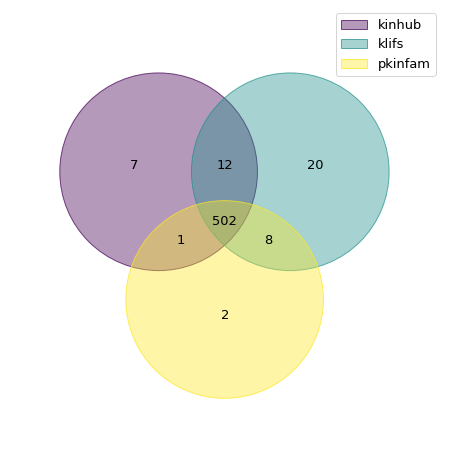

In [147]:
venn(official_uniprot_ids);

Let's build the final dataframe with all kinases:

In [239]:
kinases = (
    pd.concat([
        kinhub[["HGNC Name", "UniprotID"]].rename(columns={"HGNC Name": "Name"}).assign(source="kinhub"), 
        klifs[["HGNC Name", "UniprotID"]].rename(columns={"HGNC Name": "Name"}).assign(source="klifs"), 
        pkinfam[["Name", "UniprotID"]].assign(source="pkinfam"), 
    ], ignore_index=True)
    .drop_duplicates(subset=["UniprotID"])
)
kinases

,Name,UniprotID,source
0,AAK1,Q2M2I8,kinhub
1,ABL1,P00519,kinhub
2,ABL2,P42684,kinhub
3,ABR,Q12979,kinhub
4,TNK2,Q07912,kinhub
...,...,...,...
1080,PIK3CB,P42338,klifs
1081,PIK3CD,O00329,klifs
1082,PIK3CG,P48736,klifs
1420,PEAK3,Q6ZS72,pkinfam


## 02. Find UniProt IDs in ChEMBL targets

Get UniProt-ChEMBL mapping from EBI FTP server. Update URL to reflect new ChEMBL releases!

In [240]:
CHEMBL_VERSION = "chembl_27"
url = fr"ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/{CHEMBL_VERSION}/chembl_uniprot_mapping.txt"

In [241]:
with urllib.request.urlopen(url) as response:
    uniprot_map = pd.read_csv(response, sep="\t", skiprows=[0], names=["UniprotID", "chembl_targets", "description", "type"])
uniprot_map

,UniprotID,chembl_targets,description,type
0,P21266,CHEMBL2242,Glutathione S-transferase Mu 3,SINGLE PROTEIN
1,O00519,CHEMBL2243,Anandamide amidohydrolase,SINGLE PROTEIN
2,P19217,CHEMBL2244,Estrogen sulfotransferase,SINGLE PROTEIN
3,P97292,CHEMBL2245,Histamine H2 receptor,SINGLE PROTEIN
4,P17342,CHEMBL2247,Atrial natriuretic peptide receptor C,SINGLE PROTEIN
...,...,...,...,...
11779,Q91ZR5,CHEMBL3886121,Cation channel sperm-associated protein 1,SINGLE PROTEIN
11780,P48763,CHEMBL3886122,Sodium/hydrogen exchanger 2,SINGLE PROTEIN
11781,Q9UKU6,CHEMBL3886123,Thyrotropin-releasing hormone-degrading ectoen...,SINGLE PROTEIN
11782,Q9JJH7,CHEMBL3886124,Transient receptor potential cation channel su...,SINGLE PROTEIN


We join this new information to the human kinases list:

In [255]:
merged = pd.merge(kinases, uniprot_map[["UniprotID", "chembl_targets", "type"]], how="inner", on='UniprotID')
merged

,Name,UniprotID,source,chembl_targets,type
0,AAK1,Q2M2I8,kinhub,CHEMBL3830,SINGLE PROTEIN
1,ABL1,P00519,kinhub,CHEMBL1862,SINGLE PROTEIN
2,ABL1,P00519,kinhub,CHEMBL2096618,CHIMERIC PROTEIN
3,ABL1,P00519,kinhub,CHEMBL2111414,PROTEIN FAMILY
4,ABL1,P00519,kinhub,CHEMBL4296119,PROTEIN-PROTEIN INTERACTION
...,...,...,...,...,...
873,PIK3CG,P48736,klifs,CHEMBL3267,SINGLE PROTEIN
874,PIK3CG,P48736,klifs,CHEMBL3430881,PROTEIN COMPLEX
875,PIK3CG,P48736,klifs,CHEMBL4296106,PROTEIN COMPLEX
876,PIK3CG,P48736,klifs,CHEMBL3559703,PROTEIN COMPLEX GROUP


And save as CSV for easy reuse in other notebooks.

In [256]:
merged.to_csv(DATA /  f"human_kinases_and_chembl_targets.{CHEMBL_VERSION}.csv", index=False)

Note there's not 1:1 correspondence between UniprotID and ChEMBL ID! Some kinases are included in several ChEMBL targets:

In [257]:
merged[merged.UniprotID == "P00519"]

,Name,UniprotID,source,chembl_targets,type
1,ABL1,P00519,kinhub,CHEMBL1862,SINGLE PROTEIN
2,ABL1,P00519,kinhub,CHEMBL2096618,CHIMERIC PROTEIN
3,ABL1,P00519,kinhub,CHEMBL2111414,PROTEIN FAMILY
4,ABL1,P00519,kinhub,CHEMBL4296119,PROTEIN-PROTEIN INTERACTION
5,ABL1,P00519,kinhub,CHEMBL4296120,PROTEIN-PROTEIN INTERACTION
6,ABL1,P00519,kinhub,CHEMBL4296137,PROTEIN-PROTEIN INTERACTION
7,ABL1,P00519,kinhub,CHEMBL3885630,PROTEIN-PROTEIN INTERACTION
8,ABL1,P00519,kinhub,CHEMBL3885645,CHIMERIC PROTEIN


... and some ChEMBL targets include several kinases (e.g. chimeric proteins):

In [245]:
merged[merged.chembl_targets == "CHEMBL2096618"]

,Name,UniprotID,source,chembl_targets,type
2,ABL1,P00519,kinhub,CHEMBL2096618,CHIMERIC PROTEIN
83,BCR,P11274,kinhub,CHEMBL2096618,CHIMERIC PROTEIN


This is due to the different `type` values:

In [246]:
merged.type.value_counts()

SINGLE PROTEIN                 485
PROTEIN FAMILY                 215
PROTEIN COMPLEX                107
PROTEIN-PROTEIN INTERACTION     33
SELECTIVITY GROUP               16
PROTEIN COMPLEX GROUP           11
CHIMERIC PROTEIN                11
Name: type, dtype: int64

If we focus on `SINGLE PROTEIN` types:

In [247]:
merged[merged.type == "SINGLE PROTEIN"]

,Name,UniprotID,source,chembl_targets,type
0,AAK1,Q2M2I8,kinhub,CHEMBL3830,SINGLE PROTEIN
1,ABL1,P00519,kinhub,CHEMBL1862,SINGLE PROTEIN
9,ABL2,P42684,kinhub,CHEMBL4014,SINGLE PROTEIN
11,TNK2,Q07912,kinhub,CHEMBL4599,SINGLE PROTEIN
12,ACVR2A,P27037,kinhub,CHEMBL5616,SINGLE PROTEIN
...,...,...,...,...,...
860,PIP5K1C,O60331,klifs,CHEMBL1908383,SINGLE PROTEIN
861,PIK3CA,P42336,klifs,CHEMBL4005,SINGLE PROTEIN
865,PIK3CB,P42338,klifs,CHEMBL3145,SINGLE PROTEIN
869,PIK3CD,O00329,klifs,CHEMBL3130,SINGLE PROTEIN
